In [1]:
# 

In [2]:
#models
import numpy as np

from keras.layers import Embedding, Reshape,Concatenate, dot, Dropout, Dense,Input,Flatten,merge,concatenate
from keras import Model
from keras.models import Sequential
import tensorflow as tf
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot



def Collaborative_FilteringModel(n_users,n_items ,emb_dim):
        user_input = Input(shape=[1])
        item_input = Input(shape=[1])
        user_embedding = Embedding(output_dim=emb_dim, input_dim=n_users + 1,
                               input_length=1)(user_input)
        item_embedding = Embedding(output_dim=emb_dim, input_dim=n_items + 1,
                               input_length=1)(item_input)
        user_vecs = Flatten()(user_embedding)
        item_vecs = Flatten()(item_embedding)
        output = dot([user_vecs, item_vecs], axes=-1)
        model = Model(inputs=[user_input, item_input], outputs=output)
        return model

def Deep_networkModel(n_users,n_movies ,emb_dim):
    n_latent_factors_user = emb_dim
    n_latent_factors_movie = emb_dim

    movie_input = Input(shape=[1],name='Item')
    movie_embedding = Embedding(n_movies + 1, n_latent_factors_movie, name='Embedding_for_movies')(movie_input)
    movie_vec = Flatten(name='Flatten_Movies')(movie_embedding)
   # movie_vec = Dropout(0.2)(movie_vec)


    user_input = Input(shape=[1],name='User')
    user_vec = Flatten(name='FlattenUsers')(Embedding(n_users + 1, n_latent_factors_user,name='Embedding_for_users')(user_input))
    #user_vec = Dropout(0.2)(user_vec)
    concat =concatenate([movie_vec,user_vec],axis=-1, name='concat_')
#     import random
#     x = random.random()
#     x=x/3#----just to ensure dropout random is not too large
    concat = Dropout(0.2)(concat)
    dense = Dense(60,name='hiddenlayer1',activation='relu')(concat)
    dropout_1 = Dropout(0.2,name='Dropout')(dense)
    dense_2 = Dense(30,name='hiddenlayer2',activation='relu')(concat)
    dropout_2 = Dropout(0.2,name='Dropout')(dense_2)
    dense_3 = Dense(15,name='hidden3',activation='relu')(dense_2)
    dropout_3 = Dropout(0.2,name='Dropout')(dense_3)
    dense_4 = Dense(15,name='hidden4', activation='relu')(dense_3)


    result = Dense(1, activation='relu',name='result_node_with_relu_activation')(dense_4)

    model = Model([user_input, movie_input], result)

    return model





#trainig.................................................................................................

import math
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
# from CFModel import CFModel

RATINGS_CSV_FILE = 'ml1m_ratings.csv'
MODEL_WEIGHTS_FILE = 'ml1m_weights_exp0.h5'
K_FACTORS = 60
RNG_SEED = 144655


ratings = pd.read_csv(RATINGS_CSV_FILE, 
                      sep='\t', 
                      encoding='latin-1', 
                      usecols=['userid', 'movieid', 'user_emb_id', 'movie_emb_id', 'rating'])
max_userid = ratings['userid'].drop_duplicates().max()
max_movieid = ratings['movieid'].drop_duplicates().max()
print (len(ratings), ':number of ratings')


shuffled_ratings = ratings.sample(frac=1., random_state=RNG_SEED)
Users = shuffled_ratings['user_emb_id'].values
print ('Users:', Users, ', shape =', Users.shape)
Movies = shuffled_ratings['movie_emb_id'].values
print ('Movies:', Movies, ', shape =', Movies.shape)
Ratings = shuffled_ratings['rating'].values
print ('Ratings:', Ratings, ', shape =', Ratings.shape)

model =Deep_networkModel(max_userid, max_movieid, K_FACTORS)
model.compile(loss='mse', optimizer='adamax')
batch_size=len(Ratings)
callbacks = [EarlyStopping('val_loss', patience=2), 
             ModelCheckpoint(MODEL_WEIGHTS_FILE, save_best_only=True)]
history = model.fit([Users, Movies],Ratings, nb_epoch=30,  verbose=2, callbacks=callbacks,validation_split=.1)


loss = pd.DataFrame({'epoch': [ i + 1 for i in history.epoch ],
                     'training': [ math.sqrt(loss) for loss in history.history['loss'] ],
                     'validation': [ math.sqrt(loss) for loss in history.history['val_loss'] ]})


min_val_loss, idx = min((val, idx) for (idx, val) in enumerate(history.history['val_loss']))
print ('Minimum RMSE at epoch', '{:d}'.format(idx+1), '=', '{:.4f}'.format(math.sqrt(min_val_loss)))


Using TensorFlow backend.


1000209 :number of ratings
Users: [4136  201 5702 ...  587 2792  507] , shape = (1000209,)
Movies: [  51 3301 1689 ... 1642 1007  366] , shape = (1000209,)
Ratings: [4 2 1 ... 4 4 4] , shape = (1000209,)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


D:\anaconda\lib\site-packages\ipykernel_launcher.py:101: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 900188 samples, validate on 100021 samples
Epoch 1/30
 - 171s - loss: 0.9038 - val_loss: 0.8193
Epoch 2/30
 - 164s - loss: 0.8133 - val_loss: 0.8060
Epoch 3/30
 - 171s - loss: 0.7959 - val_loss: 0.7908
Epoch 4/30
 - 167s - loss: 0.7799 - val_loss: 0.7826
Epoch 5/30
 - 173s - loss: 0.7658 - val_loss: 0.7733
Epoch 6/30
 - 168s - loss: 0.7569 - val_loss: 0.7712
Epoch 7/30
 - 170s - loss: 0.7512 - val_loss: 0.7683
Epoch 8/30
 - 169s - loss: 0.7467 - val_loss: 0.7732
Epoch 9/30
 - 166s - loss: 0.7421 - val_loss: 0.7665
Epoch 10/30
 - 156s - loss: 0.7376 - val_loss: 0.7658
Epoch 11/30
 - 158s - loss: 0.7339 - val_loss: 0.7636
Epoch 12/30
 - 163s - loss: 0.7300 - val_loss: 0.7642
Epoch 13/30
 - 158s - loss: 0.7262 - val_loss: 0.7642
Minimum RMSE at epoch 11 = 0.8738


D:\anaconda\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  


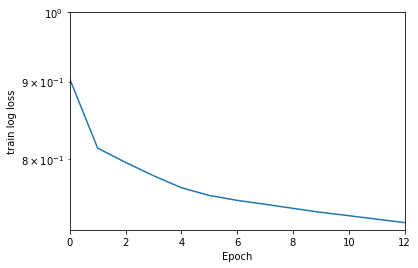

D:\anaconda\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  


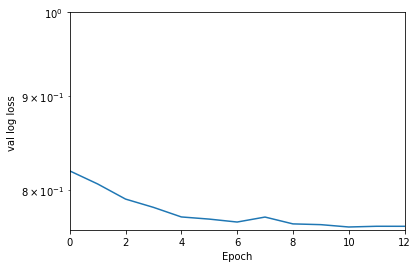

In [3]:
#plots..................................................................
pd.Series(history.history['loss']).plot(logy=True).set_ylim([0.0,1.0])
plt.xlabel("Epoch")
plt.ylabel(" train log loss ")
plt.show()
pd.Series(history.history['val_loss']).plot(logy=True).set_ylim([0.0,1.0])
plt.xlabel("Epoch")
plt.ylabel("val log loss ")
plt.show()


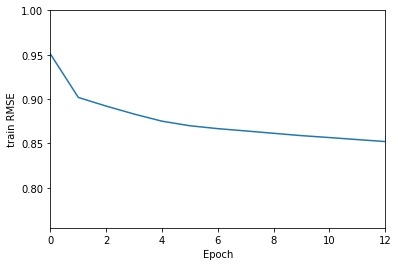

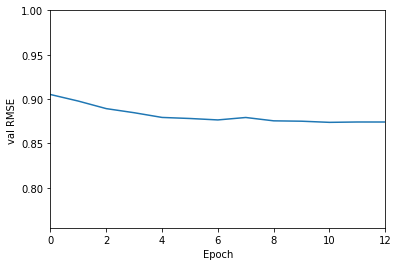

In [4]:
#plots..................................................................
pd.Series(loss['training']).plot(logy=False).set_ylim([0.755,1.0])
plt.xlabel("Epoch")
plt.ylabel(" train RMSE ")
plt.show()
pd.Series(loss['validation']).plot(logy=False).set_ylim([0.755,1.0])
plt.xlabel("Epoch")
plt.ylabel("val RMSE ")
plt.show()



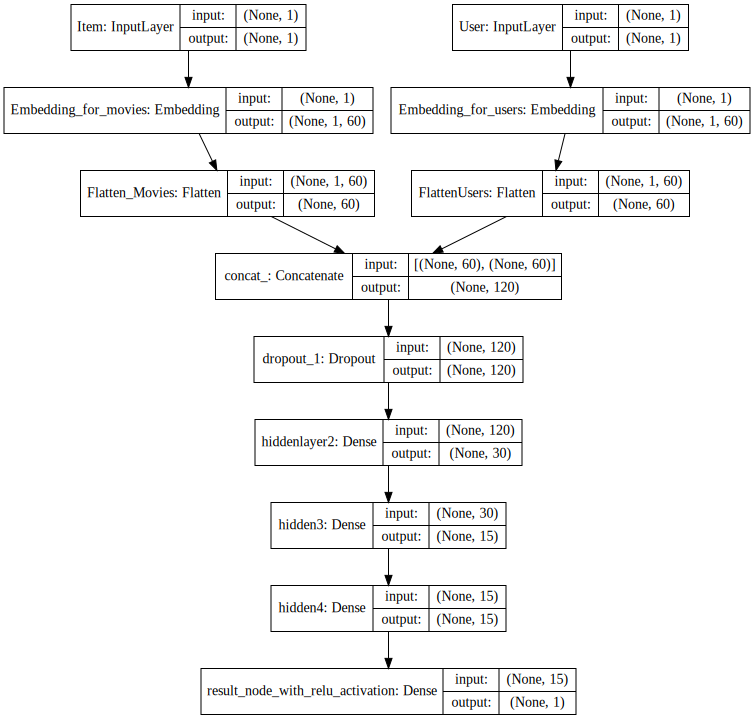

In [5]:
#architecture..................................................................
SVG(model_to_dot(model,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))

In [6]:
import pandas as pd
RATINGS_CSV_FILE = 'ml1m_ratings.csv'
USERS_CSV_FILE = 'ml1m_users.csv'
MOVIES_CSV_FILE = 'ml1m_movies.csv'
MODEL_WEIGHTS_FILE = 'ml1m_weights_exp0.h5'
K_FACTORS = 60
TEST_USER = 234#<-test user.....
top_k_ratings=10

ratings = pd.read_csv(RATINGS_CSV_FILE, sep='\t', encoding='latin-1', usecols=['userid', 'movieid', 'rating'])
max_userid = ratings['userid'].drop_duplicates().max()
max_movieid = ratings['movieid'].drop_duplicates().max()
print (len(ratings), 'ratings loaded.')

users = pd.read_csv(USERS_CSV_FILE, sep='\t', encoding='latin-1', usecols=['userid', 'gender', 'zipcode', 'age_desc', 'occ_desc'])
print( len(users), 'descriptions of', max_userid, 'users loaded.')


movies = pd.read_csv(MOVIES_CSV_FILE, sep='\t', encoding='latin-1', usecols=['movieid', 'title', 'genre'])
print (len(movies), 'descriptions of', max_movieid, 'movies loaded.')

trained_model = Deep_networkModel(max_userid, max_movieid, K_FACTORS)

trained_model.load_weights(MODEL_WEIGHTS_FILE)
trained_model.summary()

users[users['userid'] == TEST_USER]
def predict_rating(userid, movieid):

      return trained_model.predict([np.array([userid]), np.array([movieid])])[0][0]

user_ratings = ratings[ratings['userid'] == TEST_USER][['userid', 'movieid', 'rating']]
user_ratings['prediction'] = user_ratings.apply(lambda x: predict_rating(TEST_USER, x['movieid']), axis=1)

#Top K ratings for user..................................................................
user_ratings.sort_values(by='prediction', 
                         ascending=False).merge(movies, 
                                                on='movieid', 
                                                how='inner', 
                                                suffixes=['_u', '_m']).head(top_k_ratings)

1000209 ratings loaded.
6040 descriptions of 6040 users loaded.
3883 descriptions of 3952 movies loaded.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Embedding_for_movies (Embedding (None, 1, 60)        237180      Item[0][0]                       
__________________________________________________________________________________________________
Embedding_for_users (Embedding) (None, 1, 60)        362460      User[0][0]                       
____

,userid,movieid,rating,prediction,title,genre
0,234,1198,5,4.692029,Raiders of the Lost Ark (1981),Action|Adventure
1,234,1299,4,4.575796,"Killing Fields, The (1984)",Drama|War
2,234,2971,5,4.542850,All That Jazz (1979),Musical
3,234,1291,4,4.540976,Indiana Jones and the Last Crusade (1989),Action|Adventure
4,234,1672,5,4.520812,"Rainmaker, The (1997)",Drama
5,234,1242,4,4.475337,Glory (1989),Action|Drama|War
6,234,1196,4,4.449665,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Drama|Sci-Fi|War
7,234,1293,5,4.407430,Gandhi (1982),Drama
8,234,1213,5,4.377492,GoodFellas (1990),Crime|Drama
9,234,1252,5,4.361409,Chinatown (1974),Film-Noir|Mystery|Thriller


In [7]:
user_ratings.sort_values(by='prediction', 
                         ascending=False).merge(movies, 
                                                on='movieid', 
                                                how='inner', 
                                                suffixes=['_u', '_m']).head(top_k_ratings).to_csv("user_ratings_prediction_top_10.csv", 
              sep='\t', 
              header=True)